# Machine Learning Group 8

# 1. Imports

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pointbiserialr
from sklearn import metrics


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import  SelectFromModel, SelectKBest, f_classif
from sklearn.linear_model import LassoCV

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier


import time
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

### Import Datasets

In [2]:
train = pd.read_csv('train.csv', sep = ',')
train.head(5)

encounter_id country  patient_id             race  gender      age weight  \
0        533253     USA       70110        Caucasian  Female  [70-80)      ?   
1        426224     USA    29775006  AfricanAmerican    Male  [50-60)      ?   
2        634063     USA    80729253        Caucasian  Female  [60-70)      ?   
3        890610     USA     2919042  AfricanAmerican    Male  [60-70)      ?   
4        654194     USA    84871971        Caucasian  Female  [70-80)      ?   

  payer_code  outpatient_visits_in_previous_year  \
0          ?                                   0   
1          ?                                   0   
2          ?                                   0   
3         MC                                   0   
4         HM                                   1   

   emergency_visits_in_previous_year  ...  secondary_diagnosis  \
0                                  0  ...                  276   
1                                  0  ...                  785   
2                                  0  ...                  135   
3                                  0  ...                  562   
4                                  0  ...                  599   

  additional_diagnosis number_diagnoses  glucose_test_result a1c_test_result  \
0                  466                8                  NaN             NaN   
1                  162                9                  NaN             NaN   
2                  250                6                  NaN             NaN   
3                  455                5                  NaN             NaN   
4                  428                9                  NaN             NaN   

  change_in_meds_during_hospitalization  prescribed_diabetes_meds  \
0                                    No                        No   
1                                    No                       Yes   
2                                    Ch                       Yes   
3                                    No                        No   
4                                    No                        No   

                   medication  readmitted_binary  readmitted_multiclass  
0                          []                 No               >30 days  
1                 ['insulin']                 No                     No  
2  ['glimepiride', 'insulin']                 No                     No  
3                          []                 No                     No  
4                          []                 No               >30 days  

[5 rows x 31 columns]

# 2. Data Pre Processing

### 2.1 Train-Validation Split

In [3]:
df = train.copy()

In [4]:
X = df.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1)
target_multiclass = df['readmitted_multiclass']

In [5]:
X_train, X_val, y_train_multiclass, y_val_multiclass = train_test_split(X, target_multiclass, train_size=0.8, random_state=42)

### 2.2 Visualization

#### 2.2.1 Numerical Features

In [6]:
metric_features = []
for col in X_train.columns:
    if X_train[col].dtype == 'int64' or X_train[col].dtype == 'float64':
        metric_features.append(col)

print("Metric:", metric_features)

Metric: ['encounter_id', 'patient_id', 'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']


##### 2.2.1.1 Outpatient, Emergency, Inpatient Visits

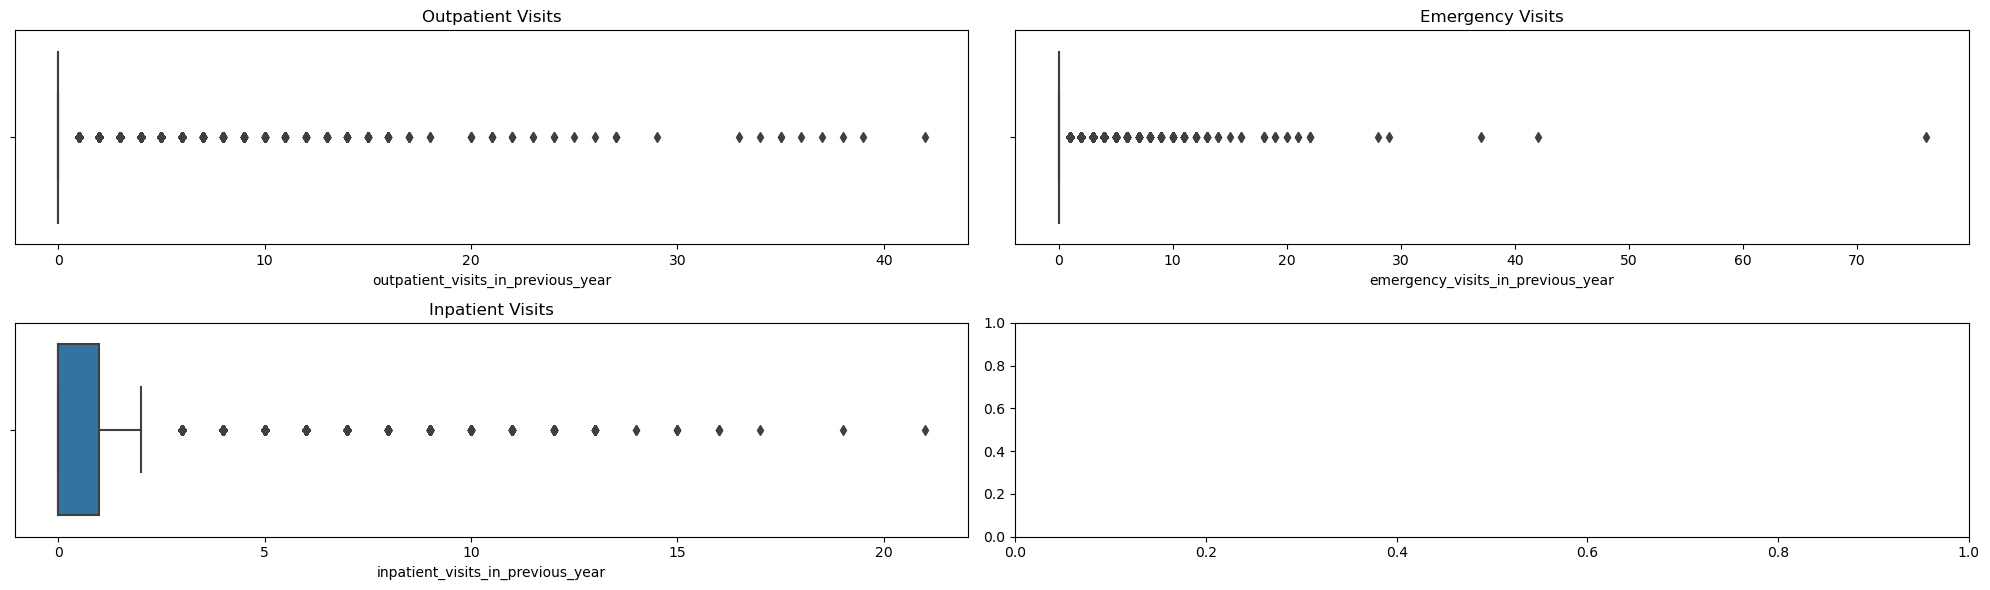

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(20, 6))

sns.boxplot(ax = axes[0][0], data = X_train, x = 'outpatient_visits_in_previous_year')
axes[0][0].set_title('Outpatient Visits')
sns.boxplot(ax = axes[0][1], data = X_train, x = 'emergency_visits_in_previous_year')
axes[0][1].set_title('Emergency Visits')
sns.boxplot(ax = axes[1][0], data = X_train, x = 'inpatient_visits_in_previous_year')
axes[1][0].set_title('Inpatient Visits')


plt.tight_layout()
plt.show()

##### 2.2.1.2 average_pulse_bpm, length_of_stay_in_hospital, number_of_medications, number_diagnoses, number_lab_tests, non_lab_procedures

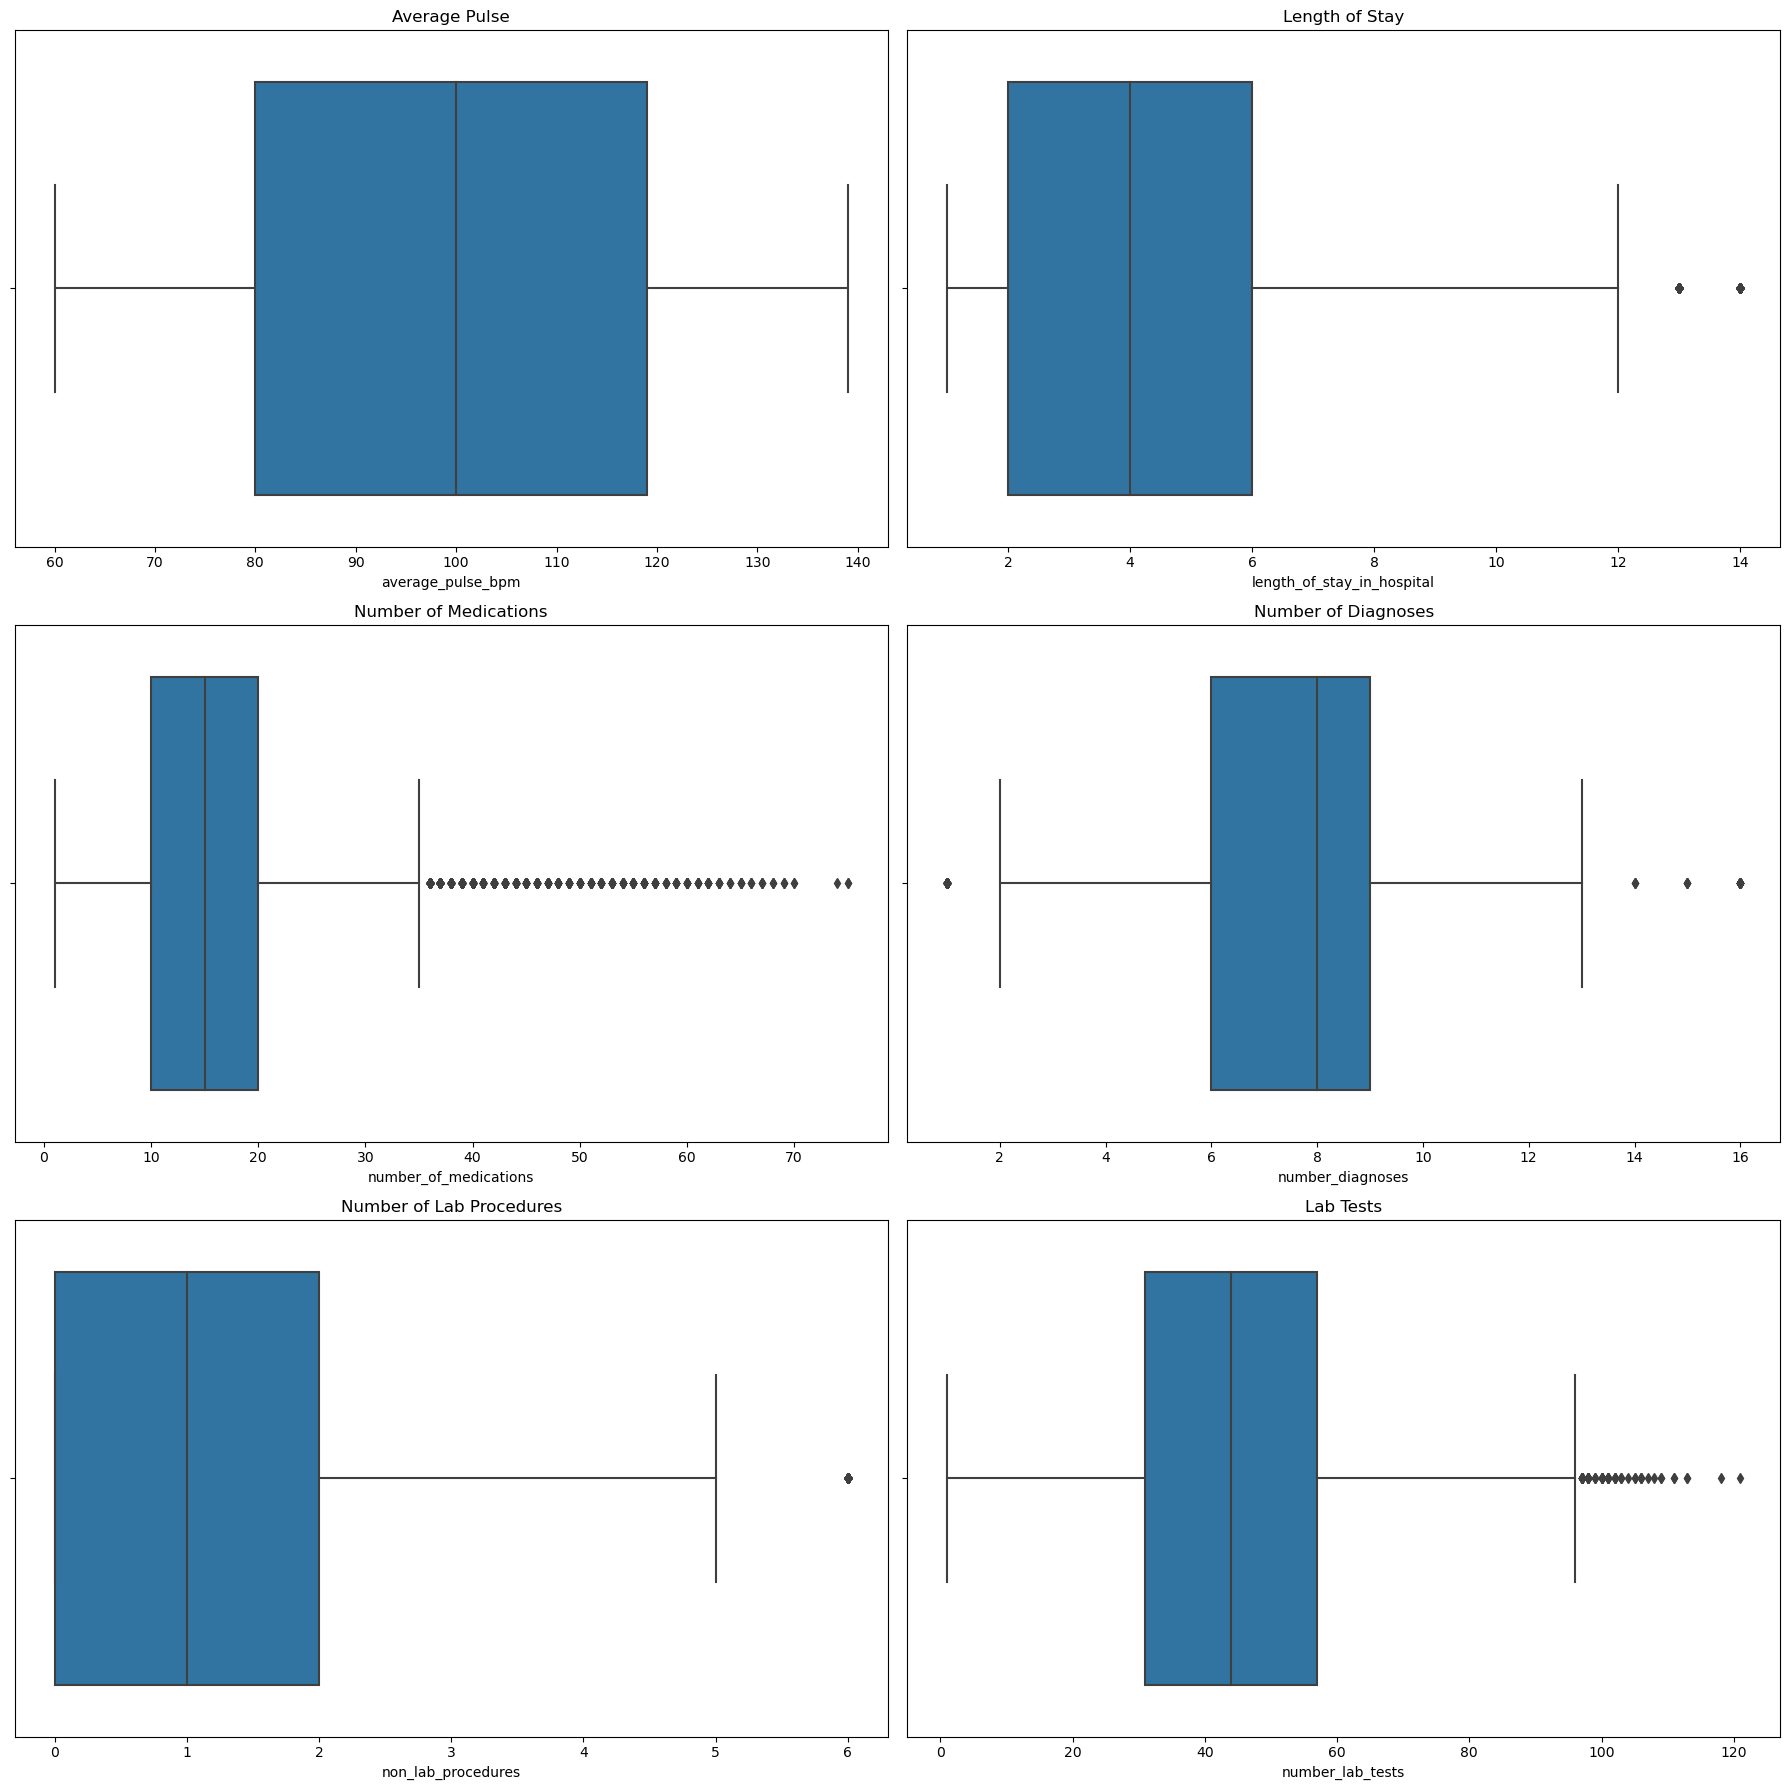

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Plot the MNT features
sns.boxplot(ax=axes[0][0], data=X_train, x='average_pulse_bpm')
axes[0][0].set_title('Average Pulse')
sns.boxplot(ax=axes[0][1], data=X_train, x='length_of_stay_in_hospital')
axes[0][1].set_title('Length of Stay')
sns.boxplot(ax=axes[1][0], data=X_train, x='number_of_medications')
axes[1][0].set_title('Number of Medications')
sns.boxplot(ax=axes[1][1], data=X_train, x='number_diagnoses')
axes[1][1].set_title('Number of Diagnoses')
sns.boxplot(ax=axes[2][0], data=X_train, x='non_lab_procedures')
axes[2][0].set_title('Number of Lab Procedures')
sns.boxplot(ax=axes[2][1], data=X_train, x='number_lab_tests')
axes[2][1].set_title('Lab Tests')

plt.tight_layout()
plt.show()

#### 2.2.2 Categorical Features

In [9]:
non_metric_features = []

for col in X_train.columns:
    if X_train[col].dtype == 'object':
        non_metric_features.append(col)

print("Non-metric:", non_metric_features)

Non-metric: ['country', 'race', 'gender', 'age', 'weight', 'payer_code', 'admission_type', 'medical_specialty', 'discharge_disposition', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'glucose_test_result', 'a1c_test_result', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'medication']


In [10]:
# value counts for all non-metric features
for col in non_metric_features:
    print(X_train[col].value_counts())
    print()

country
USA    56988
Name: count, dtype: int64

race
Caucasian          40524
AfricanAmerican    10210
?                   1224
Hispanic            1082
Other                803
Asian                340
Name: count, dtype: int64

gender
Female             30601
Male               26384
Unknown/Invalid        3
Name: count, dtype: int64

age
[70-80)     13906
[60-70)     11953
[50-60)      9209
[80-90)      9169
[40-50)      5087
[30-40)      2039
[90-100)     1487
[20-30)       842
[10-20)       382
[0-10)         87
Name: count, dtype: int64

weight
?            55165
[75-100)       740
[50-75)        520
[100-125)      373
[125-150)       80
[25-50)         56
[0-25)          28
[150-175)       17
[175-200)        7
>200             2
Name: count, dtype: int64

payer_code
?     22529
MC    18121
HM     3445
SP     2788
BC     2674
MD     1990
CP     1432
UN     1403
CM     1099
OG      604
PO      317
DM      301
WC       79
CH       78
OT       48
MP       47
SI       32
FR        1

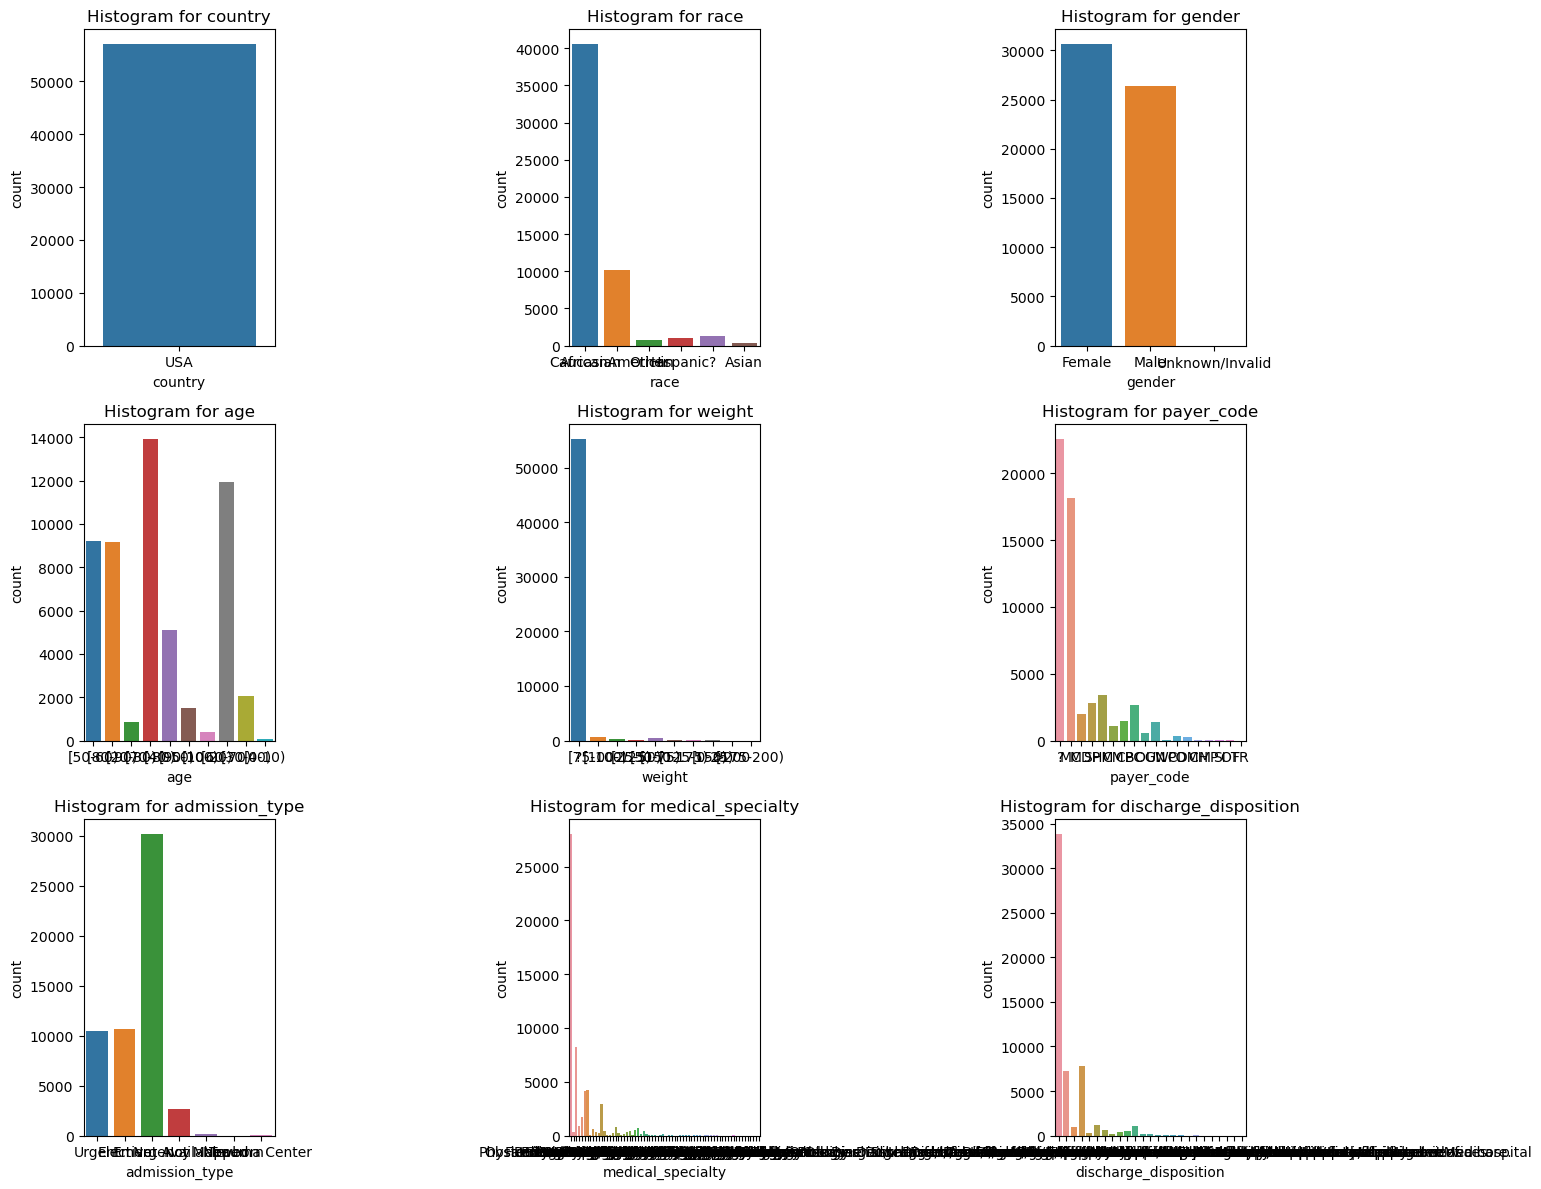

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

axes = axes.flatten()

# Plot histograms for the first 9 features
for i, feature in enumerate(non_metric_features[:9]):
    sns.countplot(data=X_train, x=feature, ax=axes[i])
    axes[i].set_title(f'Histogram for {feature}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


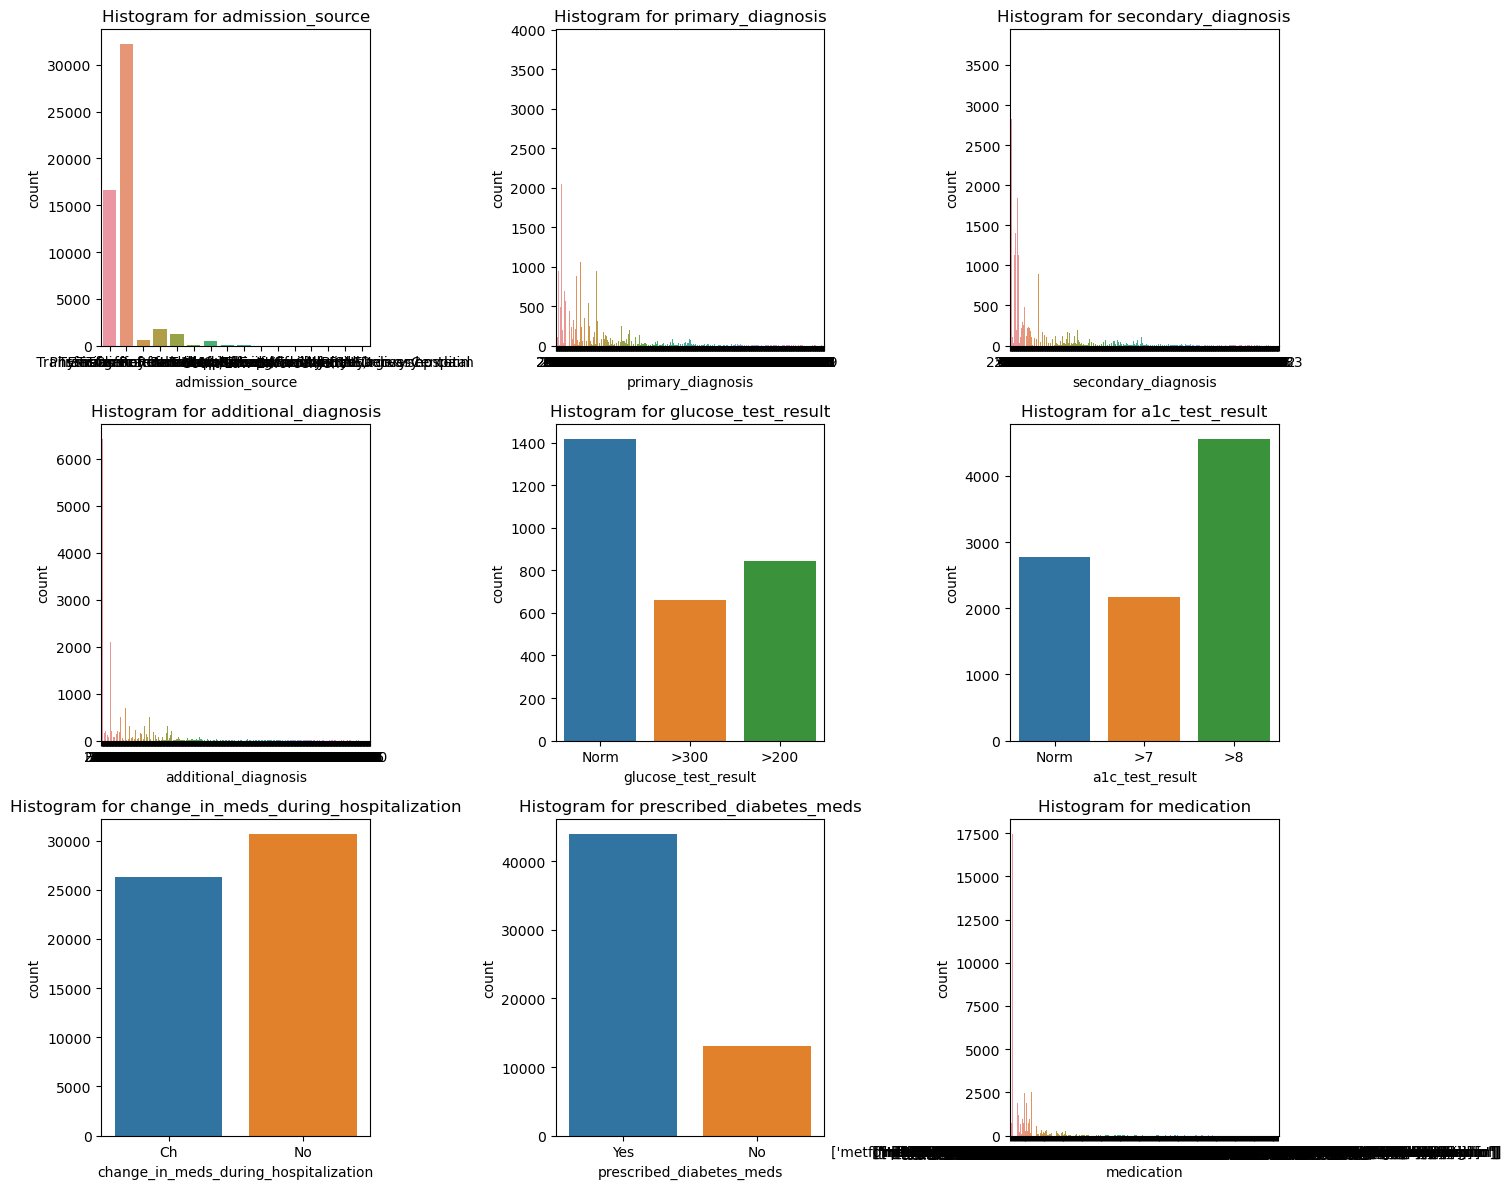

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

axes = axes.flatten()

# Plot histograms for the last 9 features
for i, feature in enumerate(non_metric_features[9:]):
    sns.countplot(data=X_train, x=feature, ax=axes[i])
    axes[i].set_title(f'Histogram for {feature}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### 2.3 Outliers

In [13]:
df_outliers = X_train.copy()
df_outliers_val = X_val.copy()

#### 2.3.1 Manual Outliers

In [14]:
df_outliers.columns

Index(['encounter_id', 'country', 'patient_id', 'race', 'gender', 'age',
       'weight', 'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication'],
      dtype='object')

In [15]:
def outliers_to_nan(df_outliers, columns_and_thresholds):
    for column, threshold in columns_and_thresholds.items():
        if column == 'number_diagnoses':
            condition = (df_outliers[column] > threshold) | (df_outliers[column] == 1)
        else:
            condition = df_outliers[column] >= threshold
        df_outliers.loc[condition, column] = None  

columns_and_thresholds = {
    'number_of_medications': 70,
    'length_of_stay_in_hospital': 14,
    'number_diagnoses': 14,
    'number_lab_tests': 111,
    'outpatient_visits_in_previous_year': 30,
    'emergency_visits_in_previous_year': 25,
    'inpatient_visits_in_previous_year': 19,
}

for df in [df_outliers, df_outliers_val]:
    outliers_to_nan(df, columns_and_thresholds)

original_size = df_outliers.shape[0]
percentage_outliers = round(df_outliers[list(columns_and_thresholds)].isna().sum().sum() / original_size * 100, 2)
print('Percentage of outliers in total:', percentage_outliers, '%')

for df in [df_outliers, df_outliers_val]:
    df[metric_features] = df[metric_features].fillna(df[metric_features].mode().iloc[0])


Percentage of outliers in total: 1.36 %


#### 2.3.2 IQR Outliers

In [16]:
q25 = df_outliers[metric_features].quantile(.25)
q75 = df_outliers[metric_features].quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df_outliers[metric].between(llim, ulim, inclusive='both'))

filters2 = pd.Series(np.all(filters2, axis=0), index=df_outliers.index)
df_2 = df_outliers[filters2]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df_outliers.shape[0], 4)* 100, '%')

Percentage of data kept after removing outliers: 66.72 %


### 2.4 Missing Values

In [17]:
df_Nan = df_outliers.copy()
df_Nan_val = df_outliers_val.copy()

In [18]:
df_Nan.drop_duplicates(inplace=True)
df_Nan_val.drop_duplicates(inplace=True)

In [19]:
df_Nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56988 entries, 43545 to 15795
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   encounter_id                           56988 non-null  int64  
 1   country                                56988 non-null  object 
 2   patient_id                             56988 non-null  int64  
 3   race                                   54183 non-null  object 
 4   gender                                 56988 non-null  object 
 5   age                                    54161 non-null  object 
 6   weight                                 56988 non-null  object 
 7   payer_code                             56988 non-null  object 
 8   outpatient_visits_in_previous_year     56988 non-null  float64
 9   emergency_visits_in_previous_year      56988 non-null  float64
 10  inpatient_visits_in_previous_year      56988 non-null  float64
 11  adm

In [20]:
df_Nan.isna().sum()/len(df_Nan)*100

encounter_id                              0.000000
country                                   0.000000
patient_id                                0.000000
race                                      4.922089
gender                                    0.000000
age                                       4.960693
weight                                    0.000000
payer_code                                0.000000
outpatient_visits_in_previous_year        0.000000
emergency_visits_in_previous_year         0.000000
inpatient_visits_in_previous_year         0.000000
admission_type                            5.204604
medical_specialty                         0.000000
average_pulse_bpm                         0.000000
discharge_disposition                     3.646382
admission_source                          6.613673
length_of_stay_in_hospital                0.000000
number_lab_tests                          0.000000
non_lab_procedures                        0.000000
number_of_medications          

In [21]:
w_r = ['?', '', 'Unknown/Invalid']
for r in w_r:
    for column in df_Nan.columns:
        df_Nan[column] = df_Nan[column].replace(r, np.nan)
        df_Nan_val[column] = df_Nan_val[column].replace(r, np.nan)

In [22]:
df_Nan.isna().sum()/len(df_Nan)*100

encounter_id                              0.000000
country                                   0.000000
patient_id                                0.000000
race                                      7.069909
gender                                    0.005264
age                                       4.960693
weight                                   96.801081
payer_code                               39.532884
outpatient_visits_in_previous_year        0.000000
emergency_visits_in_previous_year         0.000000
inpatient_visits_in_previous_year         0.000000
admission_type                            5.204604
medical_specialty                        49.106830
average_pulse_bpm                         0.000000
discharge_disposition                     3.646382
admission_source                          6.613673
length_of_stay_in_hospital                0.000000
number_lab_tests                          0.000000
non_lab_procedures                        0.000000
number_of_medications          

In [23]:
df_Nan['glucose_test_result'] = df_Nan['glucose_test_result'].replace(np.nan, 'No test done')
df_Nan['a1c_test_result'] = df_Nan['a1c_test_result'].replace(np.nan, 'No test done')

column_change = ['race', 'gender','age','admission_type','discharge_disposition','admission_source', 'primary_diagnosis']
for column in column_change:
    df_Nan[column] = df_Nan[column].replace(np.nan, df_Nan[column].mode().iloc[0])

df_Nan['payer_code'] = df_Nan['payer_code'].replace(np.nan, 'No health insurance used')

In [24]:
df_Nan_val['glucose_test_result'] = df_Nan_val['glucose_test_result'].replace(np.nan, 'No test done')
df_Nan_val['a1c_test_result'] = df_Nan_val['a1c_test_result'].replace(np.nan, 'No test done')

columns_to_replace = ['race', 'gender', 'age', 'admission_type', 'discharge_disposition', 'admission_source', 'primary_diagnosis']
for column in columns_to_replace:
    df_Nan_val[column] = df_Nan_val[column].replace(np.nan, df_Nan[column].mode().iloc[0])

df_Nan_val['payer_code'] = df_Nan_val['payer_code'].replace(np.nan, 'No health insurance used')

In [25]:
df_Nan['additional_diagnosis'] = df_Nan['additional_diagnosis'].fillna('000')
df_Nan_val['additional_diagnosis'] = df_Nan_val['additional_diagnosis'].fillna('000')

df_Nan['secondary_diagnosis'] = df_Nan['secondary_diagnosis'].fillna(df_Nan['additional_diagnosis'])
df_Nan_val['secondary_diagnosis'] = df_Nan_val['secondary_diagnosis'].fillna(df_Nan_val['additional_diagnosis'])

df_Nan['primary_diagnosis'] = df_Nan['primary_diagnosis'].fillna(df_Nan['secondary_diagnosis'])
df_Nan_val['primary_diagnosis'] = df_Nan_val['primary_diagnosis'].fillna(df_Nan_val['secondary_diagnosis'])

In [26]:
df_Nan['primary_diagnosis'] = df_Nan['primary_diagnosis'].fillna('000')
df_Nan_val['primary_diagnosis'] = df_Nan_val['primary_diagnosis'].fillna('000')

df_Nan['secondary_diagnosis'] = df_Nan['secondary_diagnosis'].fillna('000')
df_Nan_val['secondary_diagnosis'] = df_Nan_val['secondary_diagnosis'].fillna('000')

In [27]:
df_Nan.isna().sum()/len(df_Nan)*100

encounter_id                              0.000000
country                                   0.000000
patient_id                                0.000000
race                                      0.000000
gender                                    0.000000
age                                       0.000000
weight                                   96.801081
payer_code                                0.000000
outpatient_visits_in_previous_year        0.000000
emergency_visits_in_previous_year         0.000000
inpatient_visits_in_previous_year         0.000000
admission_type                            0.000000
medical_specialty                        49.106830
average_pulse_bpm                         0.000000
discharge_disposition                     0.000000
admission_source                          0.000000
length_of_stay_in_hospital                0.000000
number_lab_tests                          0.000000
non_lab_procedures                        0.000000
number_of_medications          

### 2.5 Variables Preparation

In [28]:
df_features = df_Nan.copy()
df_features_val = df_Nan_val.copy()

In [29]:
df_features = df_Nan.drop(['country','weight', 'medical_specialty'], axis=1)
df_features_val = df_Nan_val.drop(['country','weight', 'medical_specialty'], axis=1)

In [30]:
df_features['gender'].replace('Male', 1, inplace=True)
df_features['gender'].replace('Female', 0, inplace=True)
df_features_val['gender'].replace('Male', 1, inplace=True)
df_features_val['gender'].replace('Female', 0, inplace=True)

df_features['change_in_meds_during_hospitalization'].replace('Ch', 1, inplace=True)
df_features['change_in_meds_during_hospitalization'].replace('No', 0, inplace=True)
df_features_val['change_in_meds_during_hospitalization'].replace('Ch', 1, inplace=True)
df_features_val['change_in_meds_during_hospitalization'].replace('No', 0, inplace=True)

df_features['prescribed_diabetes_meds'].replace('Yes', 1, inplace=True)
df_features['prescribed_diabetes_meds'].replace('No', 0, inplace=True)
df_features_val['prescribed_diabetes_meds'].replace('Yes', 1, inplace=True)
df_features_val['prescribed_diabetes_meds'].replace('No', 0, inplace=True)


In [31]:
age_id = {'[0-10)':0, 
          '[10-20)':1, 
          '[20-30)':2, 
          '[30-40)':3, 
          '[40-50)':4, 
          '[50-60)':5,
          '[60-70)':6, 
          '[70-80)':7, 
          '[80-90)':8, 
          '[90-100)':9}
df_features['age'] = df_features.age.replace(age_id)
df_features_val['age'] = df_features_val.age.replace(age_id)

In [32]:
category_mapping = {
    'Going home': ['Discharged to home', 'Hospice / home','Discharged/transferred to home with home health service'],
    'Going to a medical facility': ['Expired', 'Expired at home. Medicaid only, hospice.', 'Expired in a medical facility. Medicaid only, hospice.',
                                    'Discharged/transferred to another short term hospital', 'Discharged/transferred to another rehab fac including rehab units of a hospital .',
                                    'Discharged/transferred to another type of inpatient care institution', 'Discharged/transferred to ICF', 'Discharged/transferred to a long term care hospital.',
                                    'Hospice / medical facility', 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
                                    'Discharged/transferred to home under care of Home IV provider', 'Discharged/transferred within this institution to Medicare approved swing bed',
                                    'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.','Discharged/transferred to SNF',
                                    'Discharged/transferred to a federal health care facility.', 'Neonate discharged to another hospital for neonatal aftercare',
                                    'Discharged/transferred/referred to this institution for outpatient services','Discharged/transferred/referred another institution for outpatient services'],
    'Lost track': ['Not Mapped', 'Left AMA'],
    'Stays in hospital': ['Admitted as an inpatient to this hospital','Still patient or expected to return for outpatient services']
}

def categorize_discharge(discharge_type):
    for category, types in category_mapping.items():
        if discharge_type in types:
            return category

df_features['discharge_category'] = df_features['discharge_disposition'].apply(categorize_discharge)
df_features_val['discharge_category'] = df_features_val['discharge_disposition'].apply(categorize_discharge)

category_counts = df_features['discharge_category'].value_counts()

df_features.drop('discharge_disposition', axis=1, inplace=True)
df_features_val.drop('discharge_disposition', axis=1, inplace=True)
print(category_counts)

discharge_category
Going home                     43289
Going to a medical facility    12812
Lost track                       876
Stays in hospital                 11
Name: count, dtype: int64


In [33]:
df_features['total_procedures'] = df_features['number_lab_tests'] + df_features['non_lab_procedures']
df_features_val['total_procedures'] = df_features_val['number_lab_tests'] + df_features_val['non_lab_procedures']

# Drop the original features
df_features.drop(['number_lab_tests', 'non_lab_procedures'], axis=1, inplace=True)
df_features_val.drop(['number_lab_tests', 'non_lab_procedures'], axis=1, inplace=True)

In [34]:
df_features['medication'] = df_features['medication'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)
def process_medication_list(medication_list):
    if not medication_list:
        return ['No medication used']
    else:
        return medication_list
df_features['medication'] = df_features['medication'].apply(process_medication_list)
df_features['medications'] = df_features['medication'].apply(lambda x: ', '.join(map(str, x))).str.replace(r'\[|\]', '')
df_features_val['medication'] = df_features_val['medication'].apply(process_medication_list)
df_features_val['medications'] = df_features_val['medication'].apply(lambda x: ', '.join(map(str, x))).str.replace(r'\[|\]', '')


#drop the medication column
df_features.drop('medication', axis=1, inplace=True)
df_features_val.drop('medication', axis=1, inplace=True)

In [35]:
def insurance_function(value):
    if value != "No health insurance used":
        return "Used insurance"
    else:
        return value

df_features['Insurance_or_not'] = df_features['payer_code'].apply(insurance_function)
df_features_val['Insurance_or_not'] = df_features_val['payer_code'].apply(insurance_function)

df_features['Insurance_or_not'].replace('Used insurance', 1, inplace=True)
df_features['Insurance_or_not'].replace('No health insurance used', 0, inplace=True)
df_features_val['Insurance_or_not'].replace('Used insurance', 1, inplace=True)
df_features_val['Insurance_or_not'].replace('No health insurance used', 0, inplace=True)

df_features.drop(['payer_code'], axis=1, inplace=True)
df_features_val.drop(['payer_code'], axis=1, inplace=True)


In [36]:
conditions = [
  (df_features['glucose_test_result'] == 'No test done') & (df_features['a1c_test_result'] == 'No test done'),
  (df_features['glucose_test_result'] != 'No test done'),
  (df_features['a1c_test_result'] != 'No test done')
]
conditions_val = [
  (df_features_val['glucose_test_result'] == 'No test done') & (df_features_val['a1c_test_result'] == 'No test done'),
  (df_features_val['glucose_test_result'] != 'No test done'),
  (df_features_val['a1c_test_result'] != 'No test done')
]


results = ['No test done', 'glucose_test_result: ' + df_features['glucose_test_result'], 'a1c_test_result: ' + df_features['a1c_test_result']]
results_val = ['No test done', 'glucose_test_result: ' + df_features_val['glucose_test_result'], 'a1c_test_result: ' + df_features_val['a1c_test_result']]


df_features['Exams_performed_results'] = np.select(conditions, results)
df_features_val['Exams_performed_results'] = np.select(conditions_val, results_val)

df_features = df_features.drop(['glucose_test_result','a1c_test_result'], axis=1)
df_features_val = df_features_val.drop(['glucose_test_result','a1c_test_result'], axis=1)

In [37]:
def categorizar_diagnostico(codigo):
        
    codigo = str(codigo)
        
    if codigo == '000':
        return 'No Diagnosis'
    elif codigo == 0:
        return 'No Diagnosis'
    elif '001' <= codigo <= '139.9':
        return 'Infection and Parasitic Diseases'
    elif '140' <= codigo <= '239.9':
        return 'Neoplasms'
    elif '240' <= codigo <= '279.9':
        return 'Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders'
    elif '280' <= codigo <= '289.9':
        return 'Diseases of Blood and Blood Forming Organs'
    elif '290' <= codigo <= '319':
        return 'Mental Disorders'
    elif '320' <= codigo <= '389.9':
        return 'Diseases of Nervous System and Sense Organs'
    elif '390' <= codigo <= '459.9':
        return 'Diseases of the Circulatory System'
    elif '460' <= codigo <= '519.9':
        return 'Diseases of the Respiratory System'
    elif '520' <= codigo <= '579.9':
        return 'Diseases of the Digestive System'
    elif '580' <= codigo <= '629.9':
        return 'Diseases of the Genitourinary System'
    elif '630' <= codigo <= '676.9':
        return 'Complications of Pregnancy, Childbirth and the Puerperium'
    elif '680' <= codigo <= '709.9':
        return 'Diseases of the Skin and Subcutaneous Tissue'
    elif '710' <= codigo <= '739.9':
        return 'Diseases of the Musculoskeletal System and Connective Tissue'
    elif '740' <= codigo <= '759.9':
        return 'Congenital Anomalies'
    elif '760' <= codigo <= '779.9':
        return 'Certain Conditions Originating in the Perinatal Period'
    elif '780' <= codigo <= '799.9':
        return 'Symptoms, Signs and Ill-defined Conditions'
    elif '800' <= codigo <= '999.9':
        return 'Injury and Poisoning'
    elif 'V01' <= codigo <= 'V82.9':
        return 'Supplementary Factors Influencing Health Status and Contact with Health Services'
    else:
        return 'Other category' 


df_features['diagnosis_category_pd'] = df_features['primary_diagnosis'].apply(categorizar_diagnostico)
df_features['diagnosis_category_sd'] = df_features['secondary_diagnosis'].apply(categorizar_diagnostico)
df_features['diagnosis_category_ad'] = df_features['additional_diagnosis'].apply(categorizar_diagnostico)

df_features_val['diagnosis_category_pd'] = df_features_val['primary_diagnosis'].apply(categorizar_diagnostico)
df_features_val['diagnosis_category_sd'] = df_features_val['secondary_diagnosis'].apply(categorizar_diagnostico)
df_features_val['diagnosis_category_ad'] = df_features_val['additional_diagnosis'].apply(categorizar_diagnostico)

In [38]:
green_diseases = [
    'Infection and Parasitic Diseases',
    'Diseases of Blood and Blood Forming Organs',
    'Mental Disorders',
    'Symptoms, Signs and Ill-defined Conditions',
    'Supplementary Factors Influencing Health Status and Contact with Health Services',
    'Other category'
]

yellow_diseases = [
    'Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders',
    'Diseases of Nervous System and Sense Organs',
    'Diseases of the Digestive System',
    'Diseases of the Genitourinary System',
    'Diseases of the Skin and Subcutaneous Tissue',
    'Certain Conditions Originating in the Perinatal Period'
]

red_diseases = [
    'Neoplasms',
    'Diseases of the Circulatory System',
    'Diseases of the Respiratory System',
    'Complications of Pregnancy, Childbirth and the Puerperium',
    'Diseases of the Musculoskeletal System and Connective Tissue',
    'Congenital Anomalies',
    'Injury and Poisoning'
]

df_features['diagnosis_category_pd'] = df_features['diagnosis_category_pd'].apply(lambda x: 1 if x in green_diseases else (2 if x in yellow_diseases else (3 if x in red_diseases else 0)))
df_features_val['diagnosis_category_pd'] = df_features_val['diagnosis_category_pd'].apply(lambda x: 1 if x in green_diseases else (2 if x in yellow_diseases else (3 if x in red_diseases else 0)))
df_features['diagnosis_category_sd'] = df_features['diagnosis_category_sd'].apply(lambda x: 1 if x in green_diseases else (2 if x in yellow_diseases else (3 if x in red_diseases else 0)))
df_features_val['diagnosis_category_sd'] = df_features_val['diagnosis_category_sd'].apply(lambda x: 1 if x in green_diseases else (2 if x in yellow_diseases else (3 if x in red_diseases else 0)))
df_features['diagnosis_category_ad'] = df_features['diagnosis_category_ad'].apply(lambda x: 1 if x in green_diseases else (2 if x in yellow_diseases else (3 if x in red_diseases else 0)))
df_features_val['diagnosis_category_ad'] = df_features_val['diagnosis_category_ad'].apply(lambda x: 1 if x in green_diseases else (2 if x in yellow_diseases else (3 if x in red_diseases else 0)))

# Sum diagnosis points for each patient
df_features['total_diagnosis_points'] = df_features.groupby('encounter_id')['diagnosis_category_pd'].transform('sum') + df_features.groupby('encounter_id')['diagnosis_category_sd'].transform('sum') + df_features.groupby('encounter_id')['diagnosis_category_ad'].transform('sum')
df_features_val['total_diagnosis_points'] = df_features_val.groupby('encounter_id')['diagnosis_category_pd'].transform('sum') + df_features_val.groupby('encounter_id')['diagnosis_category_sd'].transform('sum') + df_features_val.groupby('encounter_id')['diagnosis_category_ad'].transform('sum')

# Look for the points for each age range
age_points = { 0: 0,
              1: 0, 
              2: 0, 
              3: 0, 
              4: 1, 
              5: 2,
              6: 3,
              7: 4,
              8: 5,
              9: 6
}
df_features['age_points'] = df_features['age'].map(age_points)
df_features_val['age_points'] = df_features_val['age'].map(age_points)

# Sum total points
df_features['total_points'] = df_features.groupby('encounter_id')['age_points'].transform('sum') + df_features['total_diagnosis_points']
df_features_val['total_points'] = df_features_val.groupby('encounter_id')['age_points'].transform('sum') + df_features_val['total_diagnosis_points']


#drop age points and total diagnosis points
df_features.drop(['age_points', 'total_diagnosis_points'], axis=1, inplace=True)
df_features_val.drop(['age_points', 'total_diagnosis_points'], axis=1, inplace=True)

In [39]:
df_features.drop(['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'diagnosis_category_pd', 'diagnosis_category_sd', 'diagnosis_category_ad'], axis=1, inplace=True)
df_features_val.drop(['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis',  'diagnosis_category_pd', 'diagnosis_category_sd', 'diagnosis_category_ad'], axis=1, inplace=True)

In [40]:
df_features['admission_type'] =  df_features['admission_type'].replace(['Not Available', 'Not Mapped', 'Trauma Center', 'Newborn'], 'Not Tracked')
df_features_val['admission_type'] =  df_features_val['admission_type'].replace(['Not Available', 'Not Mapped', 'Trauma Center', 'Newborn'], 'Not Tracked')

In [41]:
occurrence_threshold = 1000
frequent_categories = df_features['admission_source'].value_counts()[df_features['admission_source'].value_counts() >= occurrence_threshold].index
df_features['admission_source'] = df_features['admission_source'].apply(lambda x: x if x in frequent_categories else 'Other')
df_features_val['admission_source'] = df_features_val['admission_source'].apply(lambda x: x if x in frequent_categories else 'Other')

In [42]:
df_features['total_visits']= df_features['inpatient_visits_in_previous_year']+df_features['outpatient_visits_in_previous_year']+df_features['emergency_visits_in_previous_year']
df_features_val['total_visits']= df_features_val['inpatient_visits_in_previous_year']+df_features_val['outpatient_visits_in_previous_year']+df_features_val['emergency_visits_in_previous_year']

In [43]:
df_features.drop(['inpatient_visits_in_previous_year', 'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)
df_features_val.drop(['inpatient_visits_in_previous_year', 'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)


In [44]:
top_10 = ['insulin','No medication used',\
          'metformin', 'metformin, insulin','glipizide' ,\
          'glyburide','glipizide, insulin',\
          'glyburide, insulin','pioglitazone, insulin','metformin, glyburide']
df_features['new_medications'] = df_features['medications'].copy()
df_features.loc[~df_features['medications'].isin(top_10), 'new_medications'] = 'Other Combination'
df_features_val['new_medications'] = df_features_val['medications'].copy()
df_features_val.loc[~df_features_val['medications'].isin(top_10), 'new_medications'] = 'Other Combination'

#drop medications column
df_features.drop(['medications'], axis = 1, inplace = True)
df_features_val.drop(['medications'], axis = 1, inplace = True)

In [45]:
# Calculate the average number of medications per day
df_features['medications_per_day'] = df_features['number_of_medications'] / df_features['length_of_stay_in_hospital']
df_features_val['medications_per_day'] = df_features_val['number_of_medications'] / df_features_val['length_of_stay_in_hospital']

In [46]:
df_features.drop(['number_of_medications', 'length_of_stay_in_hospital'], axis = 1, inplace = True)
df_features_val.drop(['number_of_medications', 'length_of_stay_in_hospital'], axis = 1, inplace = True)

In [47]:
df_features['Number_encounter'] =  df_features.groupby('patient_id')['encounter_id'].transform('count')
df_features_val['Number_encounter'] =  df_features_val.groupby('patient_id')['encounter_id'].transform('count')

In [48]:
df_features = df_features.drop(['patient_id', 'encounter_id'], axis=1)
df_features_val = df_features_val.drop(['patient_id', 'encounter_id'], axis=1)

In [49]:
df_features = df_features.reset_index(drop=True)
df_features_val = df_features_val.reset_index(drop=True)

#### Data Types

In [50]:
df_features.dtypes

race                                      object
gender                                     int64
age                                        int64
admission_type                            object
average_pulse_bpm                          int64
admission_source                          object
number_diagnoses                         float64
change_in_meds_during_hospitalization      int64
prescribed_diabetes_meds                   int64
discharge_category                        object
total_procedures                         float64
Insurance_or_not                           int64
Exams_performed_results                   object
total_points                               int64
total_visits                             float64
new_medications                           object
medications_per_day                      float64
Number_encounter                           int64
dtype: object

In [51]:
columns_to_change = {
    'gender': 'boolean',
    'change_in_meds_during_hospitalization': 'boolean',
    'prescribed_diabetes_meds': 'boolean',
    'Insurance_or_not': 'boolean',

}
df_features = df_features.astype(columns_to_change)
df_features_val = df_features_val.astype(columns_to_change)

# 3. Feature Selection

In [52]:
df_selection = df_features.copy()
df_selection_val = df_features_val.copy()

In [53]:
non_metric_features = []

for col in df_selection.columns:
    if df_selection[col].dtype == 'object':
        non_metric_features.append(col)

print("Non-metric:", non_metric_features)

Non-metric: ['race', 'admission_type', 'admission_source', 'discharge_category', 'Exams_performed_results', 'new_medications']


In [54]:
metric_features = []
for col in df_selection.columns:
    if df_selection[col].dtype == 'int64' or df_selection[col].dtype == 'float64' or df_selection[col].dtype == 'boolean':
        metric_features.append(col)

print("Metric:", metric_features)

Metric: ['gender', 'age', 'average_pulse_bpm', 'number_diagnoses', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'total_procedures', 'Insurance_or_not', 'total_points', 'total_visits', 'medications_per_day', 'Number_encounter']


## 3.1 Categorical Data

In [56]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### Chi - Squared

In [57]:
def apply_chisquare(X, y, var, alpha=0.05):
    dfObserved = pd.crosstab(y, X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index=dfObserved.index)
    
    if p < alpha:
        return "Prediction"
    else:
        return "Discard"

def select_best_cat_features(X, y, non_metric_features, threshold=0.5):
    variable_results = {}

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train_binary, y_val = y.iloc[train_index], y.iloc[val_index]

        X_train_cat = df_selection[non_metric_features]
        for var in X_train_cat.columns:
            result = apply_chisquare(X_train_cat[var], y_train_binary, var)
            if var not in variable_results:
                variable_results[var] = {"Prediction": 0, "Discard": 0}
            variable_results[var][result] += 1

    for var, results in variable_results.items():
        count_discard = results["Discard"]
        count_prediction = results["Prediction"]

        
        if count_prediction >= count_discard * threshold:
            print(f"\nKeep {var} in the model.")
        else:
            print(f"\nDiscard {var} from the model.")

select_best_cat_features(df_selection, y_train_multiclass, non_metric_features, threshold=0.5)


Discard race from the model.

Discard admission_type from the model.

Discard admission_source from the model.

Discard discharge_category from the model.

Discard Exams_performed_results from the model.

Discard new_medications from the model.


## 3.2 Encoding

### Multiclass

In [55]:
y_train_multiclass = y_train_multiclass.reset_index(drop=True)
y_val_multiclass = y_val_multiclass.reset_index(drop=True)

y_train_multiclass.replace('No', 0, inplace=True)
y_train_multiclass.replace('>30 days', 1, inplace=True)
y_train_multiclass.replace('<30 days', 2, inplace=True)

y_val_multiclass.replace('No', 0, inplace=True)
y_val_multiclass.replace('>30 days', 1, inplace=True)
y_val_multiclass.replace('<30 days', 2, inplace=True)

In [56]:
encoder2 = ce.TargetEncoder(cols=non_metric_features)

df_selection_multi = encoder2.fit_transform(df_selection, y_train_multiclass)
df_selection_val_multi = encoder2.transform(df_selection_val)

### Mutual Information - Categorical Features

In [94]:
mi_scores = mutual_info_classif(df_selection_multi[non_metric_features], y_train_multiclass)

# Create a DataFrame to show feature names and their corresponding scores
mi_scores_df = pd.DataFrame({'Feature': df_selection_multi[non_metric_features].columns, 'Mutual_Information': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual_Information', ascending=False)
mi_scores_df = mi_scores_df.reset_index(drop=True)
mi_scores_df

Feature  Mutual_Information
0       discharge_category            0.009826
1         admission_source            0.009586
2          new_medications            0.005635
3  Exams_performed_results            0.003523
4           admission_type            0.002279
5                     race            0.000000

## 3.3 Standardization

In [57]:
X_train_num_multi = df_selection_multi[metric_features]
X_train_cat_multi = df_selection_multi[non_metric_features]
X_val_num_multi = df_selection_val_multi[metric_features]
X_val_cat_multi = df_selection_val_multi[non_metric_features]

#### 3.3.1 MinMaxScaler

In [58]:
scaler_multi = MinMaxScaler()

scaler_multi.fit(X_train_num_multi)
X_train_num_scaled_multi = scaler_multi.transform(X_train_num_multi)
X_train_num_scaled_multi = pd.DataFrame(X_train_num_scaled_multi, columns = X_train_num_multi.columns).set_index(df_selection_multi.index)

X_val_num_scaled_multi = scaler_multi.transform(X_val_num_multi)
X_val_num_scaled_multi = pd.DataFrame(X_val_num_scaled_multi, columns = X_val_num_multi.columns).set_index(df_selection_val_multi.index)

## 3.4 Numerical Data

### 3.4.1 Filter Methods

#### Unvariate variables

In [95]:
variances_list = []

for train_index, val_index in skf.split(X_train_num_scaled_multi, y_train_multiclass):
    X_train_fold, X_val_fold = X_train_num_scaled_multi.iloc[train_index], X_train_num_scaled_multi.iloc[val_index]

    variances = np.var(X_train_fold, axis=0)

    variances_list.append(variances)

variances_array = np.array(variances_list)
for feature_idx, feature_name in enumerate(X_train_num_scaled_multi.columns):
    print(f"Feature: {feature_name}")
    for fold_idx in range(10):
        print(f"  Fold {fold_idx + 1}: {variances_array[fold_idx, feature_idx]}")

Feature: gender
  Fold 1: 0.2485847241281836
  Fold 2: 0.24872344508075853
  Fold 3: 0.24861100672961595
  Fold 4: 0.24859789622080464
  Fold 5: 0.24867705422503214
  Fold 6: 0.24865712311922777
  Fold 7: 0.2485935123659098
  Fold 8: 0.2486869638963293
  Fold 9: 0.24860888016831947
  Fold 10: 0.24854563872293695
Feature: age
  Fold 1: 0.030348617620638816
  Fold 2: 0.030230655536862657
  Fold 3: 0.03025282118412085
  Fold 4: 0.030279246411065837
  Fold 5: 0.030211428848092775
  Fold 6: 0.030208189733063526
  Fold 7: 0.030272077505581956
  Fold 8: 0.030299679648783256
  Fold 9: 0.030297787815650564
  Fold 10: 0.030163772442080537
Feature: average_pulse_bpm
  Fold 1: 0.08477025134216618
  Fold 2: 0.08510118685655794
  Fold 3: 0.0848797758607289
  Fold 4: 0.0851937282517759
  Fold 5: 0.08488941668302298
  Fold 6: 0.08505460740968063
  Fold 7: 0.08488316086991905
  Fold 8: 0.08512162169541496
  Fold 9: 0.08505131163487314
  Fold 10: 0.08494817283509459
Feature: number_diagnoses
  Fold 1: 0

#### Correlation Indices

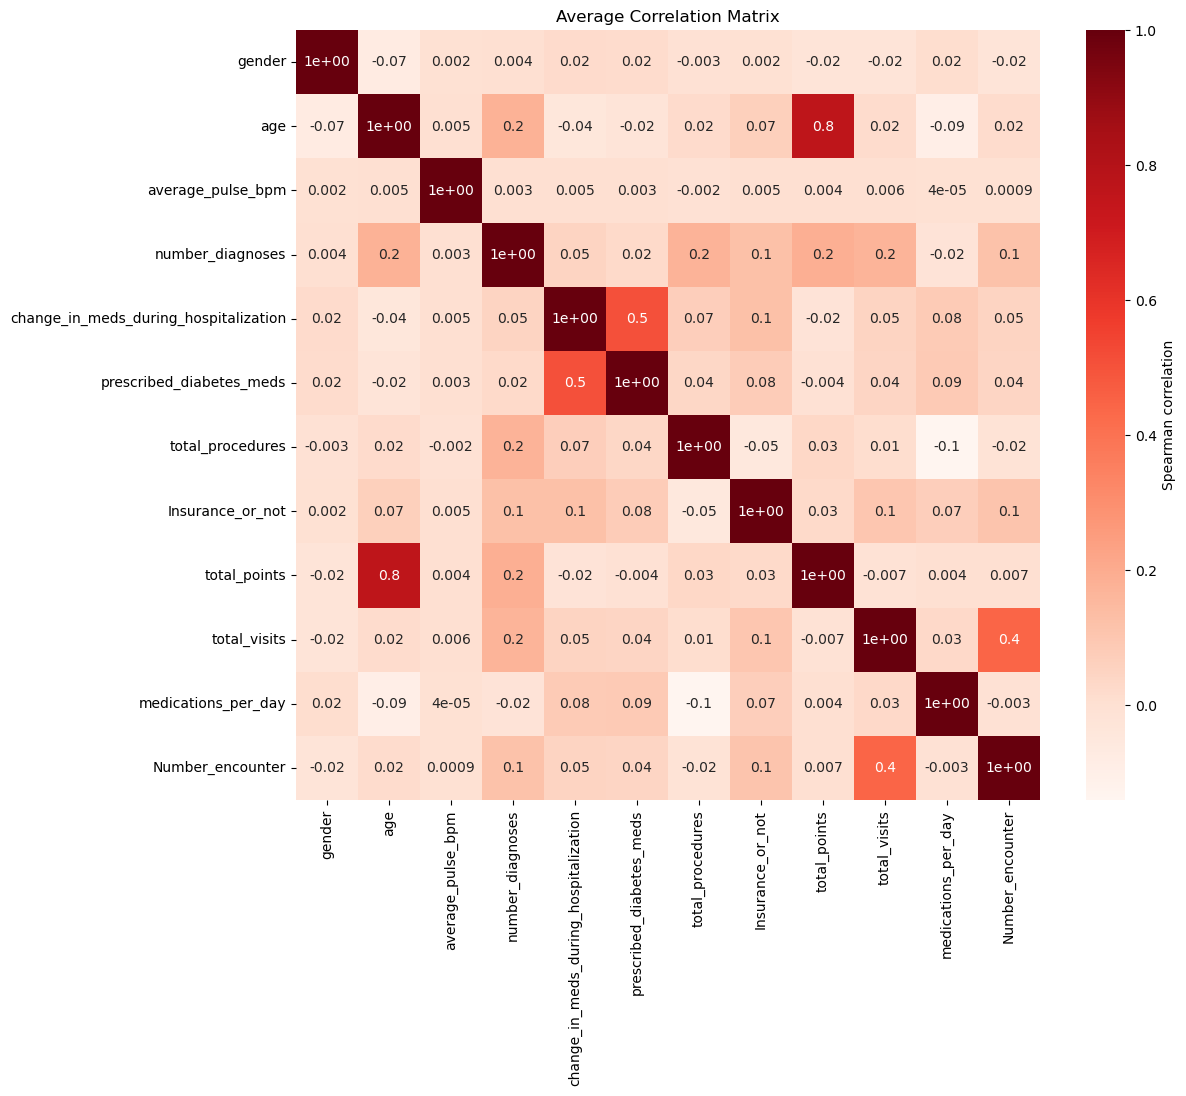

In [90]:
def cor_heatmap(cor, title="Correlation Matrix"):
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=cor, annot=True, cmap=plt.cm.Reds, fmt='.1', cbar_kws={'label': 'Spearman correlation'})
    plt.title(title)
    plt.show()

cor_matrices_list = []
feature_names = X_train_num_scaled_multi.columns 

for i, (train_index, val_index) in enumerate(skf.split(X_train_num_scaled_multi, y_train_multiclass), 1):
    X_train_fold, X_val_fold = X_train_num_scaled_multi.iloc[train_index], X_train_num_scaled_multi.iloc[val_index]

    # Calculate correlation matrix for the training fold
    cor_matrix = X_train_fold.corr(method='spearman')

    # Append the correlation matrix to the list
    cor_matrices_list.append(cor_matrix)

# Calculate the average correlation matrix
avg_cor_matrix = np.mean(cor_matrices_list, axis=0)

# Convert the NumPy array to a DataFrame
avg_cor_matrix = pd.DataFrame(avg_cor_matrix, index=feature_names, columns=feature_names)

# Plot the average correlation matrix
cor_heatmap(avg_cor_matrix, title="Average Correlation Matrix")

### 3.4.2 Wrapper Methods

#### RFE with Logistic Regression

In [93]:
# nof_list = np.arange(4,df_selection.shape[1])

# # Variables to store the optimum features
# nof = 0
# high_score = 0

# # Lists to store training and validation scores
# train_score_list = []
# val_score_list = []

# # Initialize StratifiedKFold for cross-validation
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# for n in range(len(nof_list)):
#     model = LogisticRegression()
#     rfe = RFE(estimator=model, n_features_to_select=nof_list[n])

#     # Lists to store scores for each fold
#     fold_train_scores = []
#     fold_val_scores = []

#     for train_index, val_index in skf.split(X_train_num_scaled_multi, y_train_multiclass):
#         X_train_fold, X_val_fold = X_train_num_scaled_multi.iloc[train_index], X_train_num_scaled_multi.iloc[val_index]
#         y_train_fold, y_val_fold = y_train_multiclass.iloc[train_index], y_train_multiclass.iloc[val_index]

#         X_train_rfe = rfe.fit_transform(X_train_fold, y_train_fold)
#         X_val_rfe = rfe.transform(X_val_fold)

#         model.fit(X_train_rfe, y_train_fold)

#         # Store results on training data
#         fold_train_score = model.score(X_train_rfe, y_train_fold)
#         fold_train_scores.append(fold_train_score)

#         # Store results on validation data
#         fold_val_score = model.score(X_val_rfe, y_val_fold)
#         fold_val_scores.append(fold_val_score)

#     # Calculate average scores for this number of features
#     avg_train_score = np.mean(fold_train_scores)
#     avg_val_score = np.mean(fold_val_scores)

#     train_score_list.append(avg_train_score)
#     val_score_list.append(avg_val_score)

#     # Check for the best score
#     if avg_val_score >= high_score:
#         high_score = avg_val_score
#         nof = nof_list[n]

# # Fit the model with the optimum number of features
# model = LogisticRegression()
# rfe = RFE(estimator=model, n_features_to_select=nof)
# X_train_rfe = rfe.fit_transform(X_train_num_scaled_multi, y_train_multiclass)
# model.fit(X_train_rfe, y_train_multiclass)

# # Storing selected features
# selected_features_lg = pd.Series(rfe.support_, index=X_train_num_scaled_multi.columns)

# print("Optimum number of features:", nof)
# print("Average Score with %d features:" % nof, high_score)
# print(f"Features to select:\n{selected_features_lg}")

In [59]:
selected_features_lg = ['age', 'number_diagnoses', 'total_visits','medications_per_day', 'Number_encounter' ]

#### RFE with Decisions Trees

In [99]:
# nof_list = np.arange(4,df_selection.shape[1])

# # Variables to store the optimum features
# nof = 0
# high_score = 0

# # Lists to store training and validation scores
# train_score_list = []
# val_score_list = []

# # Initialize StratifiedKFold for cross-validation
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# for n in range(len(nof_list)):
#     model = LogisticRegression()
#     rfe = RFE(estimator=model, n_features_to_select=nof_list[n])

#     # Lists to store scores for each fold
#     fold_train_scores = []
#     fold_val_scores = []

#     for train_index, val_index in skf.split(X_train_num_scaled_multi, y_train_multiclass):
#         X_train_fold, X_val_fold = X_train_num_scaled_multi.iloc[train_index], X_train_num_scaled_multi.iloc[val_index]
#         y_train_fold, y_val_fold = y_train_multiclass.iloc[train_index], y_train_multiclass.iloc[val_index]

#         X_train_rfe = rfe.fit_transform(X_train_fold, y_train_fold)
#         X_val_rfe = rfe.transform(X_val_fold)

#         model.fit(X_train_rfe, y_train_fold)

#         # Store results on training data
#         fold_train_score = model.score(X_train_rfe, y_train_fold)
#         fold_train_scores.append(fold_train_score)

#         # Store results on validation data
#         fold_val_score = model.score(X_val_rfe, y_val_fold)
#         fold_val_scores.append(fold_val_score)

#     # Calculate average scores for this number of features
#     avg_train_score = np.mean(fold_train_scores)
#     avg_val_score = np.mean(fold_val_scores)

#     train_score_list.append(avg_train_score)
#     val_score_list.append(avg_val_score)

#     # Check for the best score
#     if avg_val_score >= high_score:
#         high_score = avg_val_score
#         nof = nof_list[n]

# # Fit the model with the optimum number of features
# model = DecisionTreeClassifier()
# rfe = RFE(estimator=model, n_features_to_select=nof)
# X_train_rfe = rfe.fit_transform(X_train_num_scaled_multi, y_train_multiclass)
# model.fit(X_train_rfe, y_train_multiclass)

# # Storing selected features
# selected_features_dt = pd.Series(rfe.support_, index=X_train_num_scaled_multi.columns)

# print("Optimum number of features:", nof)
# print("Average Score with %d features:" % nof, high_score)
# print(f"Features to select:\n{selected_features_dt}")

In [60]:
selected_features_dt = ['average_pulse_bpm', 'total_procedures','total_points','medications_per_day','Number_encounter' ]

### 3.4.3 Embebed Methods

#### Lasso

In [65]:
# def plot_importance(coef,name):
#     imp_coef = coef.sort_values()
#     plt.figure(figsize=(8,10))
#     imp_coef.plot(kind = "barh")
#     plt.title("Feature importance using " + name + " Model")
#     plt.show()

In [107]:
# def plot_importance(coef, names, model_type, title="Feature Importance"):
#     imp_coef = pd.Series(coef, index=names)
#     imp_coef = imp_coef.sort_values()
    
#     plt.figure(figsize=(8, 10))
#     imp_coef.plot(kind="barh")
#     plt.title(f"{title} using {model_type} Model")
#     plt.show()

# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# reg = LassoCV()
# # Lists to store selected features for each fold
# selected_features_list = []

# for train_index, val_index in skf.split(X_train_num_scaled_multi, y_train_multiclass):
#     X_train_fold, X_val_fold = X_train_num_scaled_multi.iloc[train_index], X_train_num_scaled_multi.iloc[val_index]
#     y_train_fold, y_val_fold = y_train_multiclass.iloc[train_index], y_train_multiclass.iloc[val_index]

#     reg.fit(X_train_fold, y_train_fold)
#     coef_fold = pd.Series(reg.coef_, index=X_train_fold.columns)
#     selected_features_fold = coef_fold[coef_fold != 0].index
#     selected_features_list.append(selected_features_fold)

# # Combine selected features from all folds
# selected_feat_lasso = set.intersection(*map(set, selected_features_list))

# # Display results
# print('Total features: {}'.format(X_train_num_scaled_multi.shape[1]))
# print('Selected features across all folds: {}'.format(len(selected_feat_lasso)))
# print('Variables eliminated by Lasso: {}'.format(sum(reg.coef_ == 0)))
# print('Selected features:', selected_feat_lasso)

# # Plotting the feature importance
# plot_importance(reg.coef_, X_train_num_scaled_multi.columns, 'Lasso', title='Lasso Feature Importance')


In [61]:
selected_feat_lasso = ['Number_encounter', 'prescribed_diabetes_meds', 'total_points', 'average_pulse_bpm', 'Insurance_or_not', 'gender', 'total_visits', 'age', 'medications_per_day', 'change_in_meds_during_hospitalization', 'total_procedures', 'number_diagnoses']

#### Ridge

In [109]:

# sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2', solver='liblinear'))

# selected_features_list = []

# for train_index, val_index in skf.split(X_train_num_scaled_multi, y_train_multiclass):
#     X_train_fold, X_val_fold = X_train_num_scaled_multi.iloc[train_index], X_train_num_scaled_multi.iloc[val_index]
#     y_train_fold, y_val_fold = y_train_multiclass.iloc[train_index], y_train_multiclass.iloc[val_index]

#     sel_.fit(X_train_fold, np.ravel(y_train_fold, order='C'))
#     selected_features_fold = X_train_num_scaled_multi.columns[(sel_.get_support())]
#     selected_features_list.append(selected_features_fold)

# # Combine selected features from all folds
# selected_feat_ridge = set.intersection(*map(set, selected_features_list))

# print('Total features: {}'.format(X_train_num_scaled_multi.shape[1]))
# print('Selected features across all folds: {}'.format(len(selected_feat_ridge)))
# print('Features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)))
# print('Selected features:', selected_feat_ridge)

In [62]:
selected_feat_ridge = ['total_visits', 'Number_encounter']

#### Decision Tree

<Axes: xlabel='Value', ylabel='Col'>

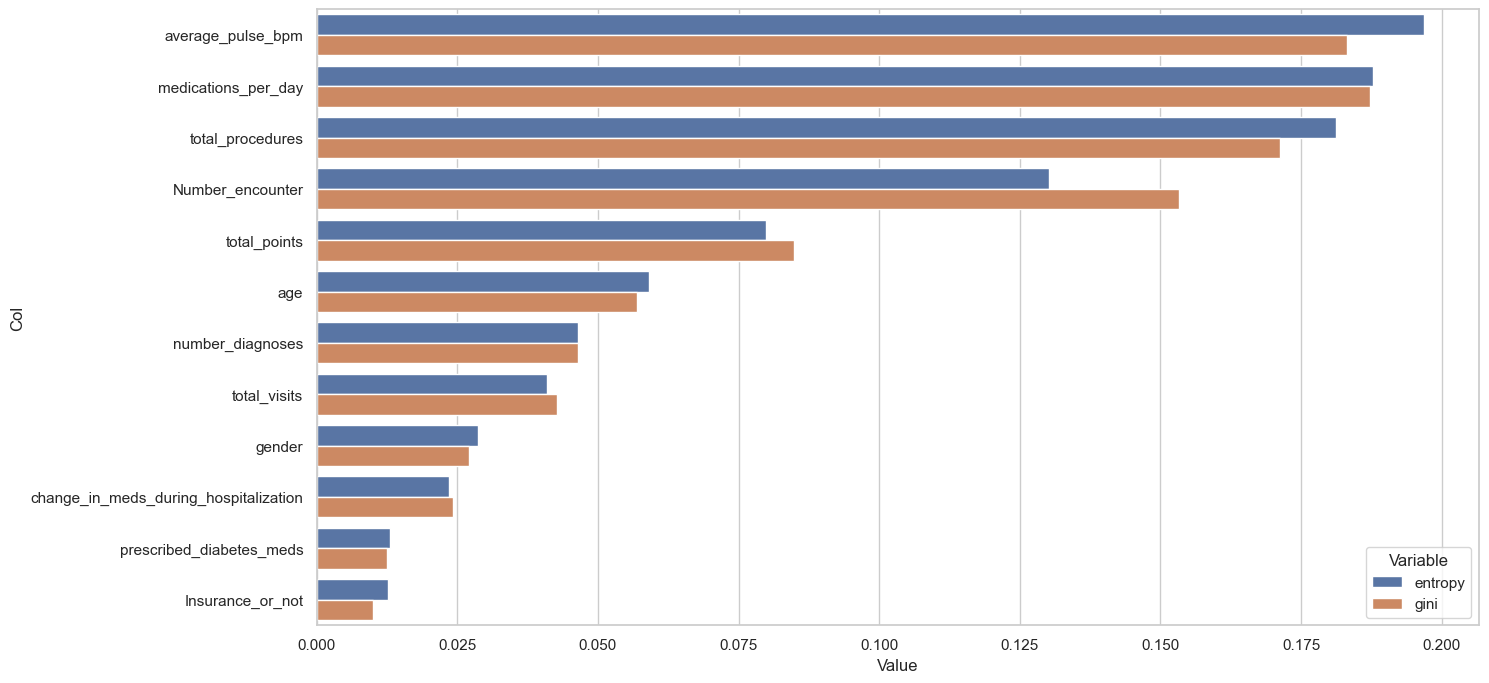

In [68]:
sns.set(style="whitegrid")

gini_importance = DecisionTreeClassifier().fit(X_train_num_scaled_multi, y_train_multiclass).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train_num_scaled_multi, y_train_multiclass).feature_importances_

zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_train_num_scaled_multi.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

#### ANOVA

In [67]:
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# k_best = SelectKBest(score_func=f_classif)

# # Lists to store selected features for each fold
# selected_features_list = []

# for train_index, val_index in skf.split(X_train_num_scaled_multi, y_train_multiclass):
#     X_train_fold, X_val_fold = X_train_num_scaled_multi.iloc[train_index], X_train_num_scaled_multi.iloc[val_index]
#     y_train_fold, y_val_fold = y_train_multiclass.iloc[train_index], y_train_multiclass.iloc[val_index]

#     # Set k to the desired number of features
#     k_best.k = min(4, X_train_fold.shape[1])  

#     # Fit and transform the training data
#     X_train_fold_selected = k_best.fit_transform(X_train_fold, y_train_fold)

#     # Get the selected features and store them
#     selected_features_fold = X_train_fold.columns[k_best.get_support()]
#     selected_features_list.append(selected_features_fold)

# # Combine selected features from all folds
# selected_feat_anova = set.intersection(*map(set, selected_features_list))

# # Display results
# print('Total features: {}'.format(X_train_num_scaled_multi.shape[1]))
# print('Selected features across all folds: {}'.format(len(selected_feat_anova)))
# print('Selected features:', selected_feat_anova)

In [64]:
selected_feat_anova = ['total_visits', 'number_diagnoses', 'prescribed_diabetes_meds', 'Number_encounter']

## 3.5 Decisions

In [65]:
df_models_multi = pd.concat([X_train_num_scaled_multi, X_train_cat_multi], axis=1)
df_models_val_multi =  pd.concat([X_val_num_scaled_multi, X_val_cat_multi], axis=1)

In [66]:
selected_features_data = []

rfe_lg = selected_features_lg
rfe_dt = selected_features_dt
lasso_features = selected_feat_lasso
ridge_features = selected_feat_ridge
anova_features = selected_feat_anova

dt_features = ['average_pulse_bpm', 'medications_per_day', 'total_procedures', 'Number_encounter', 'total_points','age']
corr_matrix = ['gender', 'age','average_pulse_bpm',  'number_diagnoses', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'total_procedures', 'Insurance_or_not','total_points','total_visits', 'medications_per_day', 'Number_encounter']

for feature in X_train_num_scaled_multi.columns:
    rfe_logistic = 'Discard'
    rfe_decision_tree = 'Discard'
    lasso = 'Discard'  
    ridge = 'Discard'  
    dt = 'Discard'
    anova = 'Discard'

    if feature in rfe_lg:
        rfe_logistic = 'Keep'

    if feature in rfe_dt:
        rfe_decision_tree = 'Keep'

    if feature in lasso_features:
        lasso = 'Keep'

    if feature in ridge_features:
        ridge = 'Keep'
    
    if feature in dt_features:
        dt = 'Keep'

    if feature in anova_features:
        anova = 'Keep'
    
    discard_count = [rfe_logistic, rfe_decision_tree, lasso, ridge, dt, anova].count('Discard')
    decision = 'Discard' if discard_count > 3 else 'Keep'

    # Append the result to the selected_features_data list
    selected_features_data.append({'Feature': feature,'RFE Logistic':rfe_logistic ,'RFE DT' : rfe_decision_tree,'Lasso': lasso, 'Ridge': ridge, 'Decision Tree': dt, 'ANOVA': anova, 'Decision': decision})

# Create a DataFrame from the list of results
selected_features_df = pd.DataFrame(selected_features_data)

# Print the resulting DataFrame 
selected_features_df

Feature RFE Logistic   RFE DT Lasso  \
0                                  gender      Discard  Discard  Keep   
1                                     age         Keep  Discard  Keep   
2                       average_pulse_bpm      Discard     Keep  Keep   
3                        number_diagnoses         Keep  Discard  Keep   
4   change_in_meds_during_hospitalization      Discard  Discard  Keep   
5                prescribed_diabetes_meds      Discard  Discard  Keep   
6                        total_procedures      Discard     Keep  Keep   
7                        Insurance_or_not      Discard  Discard  Keep   
8                            total_points      Discard     Keep  Keep   
9                            total_visits         Keep  Discard  Keep   
10                    medications_per_day         Keep     Keep  Keep   
11                       Number_encounter         Keep     Keep  Keep   

      Ridge Decision Tree    ANOVA Decision  
0   Discard       Discard  Discard  Discard  
1   Discard          Keep  Discard     Keep  
2   Discard          Keep  Discard     Keep  
3   Discard       Discard     Keep     Keep  
4   Discard       Discard  Discard  Discard  
5   Discard       Discard     Keep  Discard  
6   Discard          Keep  Discard     Keep  
7   Discard       Discard  Discard  Discard  
8   Discard          Keep  Discard     Keep  
9      Keep       Discard     Keep     Keep  
10  Discard          Keep  Discard     Keep  
11     Keep          Keep     Keep     Keep

In [72]:
X_train_multi = df_models_multi.drop(['gender','change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'Insurance_or_not', 'admission_type', 'race'], axis=1)
X_val_multi = df_models_val_multi.drop(['gender', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'Insurance_or_not','admission_type', 'race'], axis=1)

In [73]:
X_train_multi.shape

(56988, 12)

# 4. Modeling

#### OverSampling

In [74]:
smote = SMOTE(random_state=42)
X_train_oversampled_multi, y_train_oversampled_multi = smote.fit_resample(X_train_multi, y_train_multiclass)
print(len(X_train_oversampled_multi), len(y_train_oversampled_multi))

92175 92175


In [132]:
# def evaluate_models2(X_train, X_val, y_train, y_val, models, average='weighted'):
#     timer = []
#     metrics = {
#         'time': [],
#         'train_f1': [],
#         'val_f1': [],
#         'precision': [],
#         'recall': [],
#     }

#     for model_name, model in models.items():
#         # Train the model
#         begin = time.perf_counter()
#         model.fit(X_train, y_train)
#         end = time.perf_counter()

#         # Make predictions on training and validation sets
#         y_train_pred = model.predict(X_train)
#         y_val_pred = model.predict(X_val)

#         # Calculate precision, recall, and F1 scores
#         train_f1 = f1_score(y_train, y_train_pred, average=average)
#         val_f1 = f1_score(y_val, y_val_pred, average=average)
#         precision = precision_score(y_val, y_val_pred, average=average)
#         recall = recall_score(y_val, y_val_pred, average=average)

#         metrics['time'].append(end - begin)
#         metrics['train_f1'].append(train_f1)
#         metrics['val_f1'].append(val_f1)
#         metrics['precision'].append(precision)
#         metrics['recall'].append(recall)

#     avg_time = np.mean(metrics['time'])
#     avg_train_f1 = np.mean(metrics['train_f1'])
#     avg_val_f1 = np.mean(metrics['val_f1'])
#     avg_precision = np.mean(metrics['precision'])
#     avg_recall = np.mean(metrics['recall'])

#     std_time = np.std(metrics['time'])
#     std_train_f1 = np.std(metrics['train_f1'])
#     std_val_f1 = np.std(metrics['val_f1'])
#     std_precision = np.std(metrics['precision'])
#     std_recall = np.std(metrics['recall'])

#     return avg_time, avg_train_f1, avg_val_f1, avg_precision, avg_recall, std_time, std_train_f1, std_val_f1, std_precision, std_recall

# def show_results2(df, X_train, X_val, y_train, y_val, models, average='weighted'):
#     count = 0

#     for model_name, model in models.items():
#         avg_time, avg_train_f1, avg_val_f1, avg_precision, avg_recall, std_time, std_train_f1, std_val_f1, std_precision, std_recall = evaluate_models2(X_train, X_val, y_train, y_val, {model_name: model}, average=average)

#         # Ensure the DataFrame has enough rows
#         if count >= len(df):
#             df.loc[df.shape[0]] = [np.nan] * df.shape[1]

#         # Calculate overfitting
#         overfitting = avg_train_f1 - avg_val_f1

#         # Assign values to the DataFrame
#         df.iloc[count] = f"{avg_time:.3f}+/-{std_time:.2f}", f"{avg_train_f1:.3f}+/-{std_train_f1:.2f}", f"{avg_val_f1:.3f}+/-{std_val_f1:.2f}", f"{overfitting:.3f}", f"{avg_precision:.3f}+/-{std_precision:.2f}", f"{avg_recall:.3f}+/-{std_recall:.2f}"
#         count += 1

#     return df

# models_to_evaluate2 = {
#     'LogisticRegression': LogisticRegression(),
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'DecisionTreeClassifier': DecisionTreeClassifier(),
#     'MLPClassifier': MLPClassifier(),
#     'GaussianNB': GaussianNB(),
# }

# df_all = pd.DataFrame(
#     columns=['Time', 'Train_F1', 'Validation_F1', 'Overfitting', 'Precision', 'Recall'],
#     index=list(models_to_evaluate2.keys())
# )

# show_results2(df_all, X_train_oversampled_multi, X_val_multi, y_train_oversampled_multi, y_val_multiclass, models_to_evaluate2, average='weighted')

In [133]:

# models_to_evaluate2 = {
#     'LogisticRegression': LogisticRegression(solver = 'sag', penalty= 'l2', C= 10.0),
#     'KNeighborsClassifier':  KNeighborsClassifier(n_neighbors=2, weights='distance', p=1, algorithm='auto'),
#     'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=1, min_samples_leaf=199, min_samples_split=117, random_state=42),
#     'MLPClassifier': MLPClassifier(hidden_layer_sizes=(8), learning_rate_init=0.015, learning_rate='adaptive', solver='adam', activation='relu', max_iter=200, random_state=42),
#     'GaussianNB': GaussianNB(var_smoothing = 1e-07),
# }

# df_all2 = pd.DataFrame(
#     columns=['Time', 'Train_F1', 'Validation_F1', 'Overfitting', 'Precision', 'Recall'],
#     index=list(models_to_evaluate2.keys())
# )
# show_results2(df_all2,X_train_oversampled_multi, X_val_multi, y_train_oversampled_multi, y_val_multiclass, models_to_evaluate2, average='weighted')


For the OverSampled data Multiclass the best model would be MLP

#### UnderSampling

In [75]:
undersampler = RandomUnderSampler(random_state=42)
X_train_undersampled_multi, y_train_undersampled_multi = undersampler.fit_resample(X_train_multi, y_train_multiclass)

In [134]:
# def evaluate_models3(X_train, X_val, y_train, y_val, models, average='weighted'):
#     timer = []
#     metrics = {
#         'time': [],
#         'train_f1': [],
#         'val_f1': [],
#         'precision': [],
#         'recall': [],
#     }

#     for model_name, model in models.items():
#         # Train the model
#         begin = time.perf_counter()
#         model.fit(X_train, y_train)
#         end = time.perf_counter()

#         # Make predictions on training and validation sets
#         y_train_pred = model.predict(X_train)
#         y_val_pred = model.predict(X_val)

#         # Calculate precision, recall, and F1 scores
#         train_f1 = f1_score(y_train, y_train_pred, average=average)
#         val_f1 = f1_score(y_val, y_val_pred, average=average)
#         precision = precision_score(y_val, y_val_pred, average=average)
#         recall = recall_score(y_val, y_val_pred, average=average)

#         metrics['time'].append(end - begin)
#         metrics['train_f1'].append(train_f1)
#         metrics['val_f1'].append(val_f1)
#         metrics['precision'].append(precision)
#         metrics['recall'].append(recall)

#     avg_time = np.mean(metrics['time'])
#     avg_train_f1 = np.mean(metrics['train_f1'])
#     avg_val_f1 = np.mean(metrics['val_f1'])
#     avg_precision = np.mean(metrics['precision'])
#     avg_recall = np.mean(metrics['recall'])

#     std_time = np.std(metrics['time'])
#     std_train_f1 = np.std(metrics['train_f1'])
#     std_val_f1 = np.std(metrics['val_f1'])
#     std_precision = np.std(metrics['precision'])
#     std_recall = np.std(metrics['recall'])

#     return avg_time, avg_train_f1, avg_val_f1, avg_precision, avg_recall, std_time, std_train_f1, std_val_f1, std_precision, std_recall

# def show_results3(df, X_train, X_val, y_train, y_val, models, average='weighted'):
#     count = 0

#     for model_name, model in models.items():
#         avg_time, avg_train_f1, avg_val_f1, avg_precision, avg_recall, std_time, std_train_f1, std_val_f1, std_precision, std_recall = evaluate_models3(X_train, X_val, y_train, y_val, {model_name: model}, average=average)

#         # Ensure the DataFrame has enough rows
#         if count >= len(df):
#             df.loc[df.shape[0]] = [np.nan] * df.shape[1]

#         # Calculate overfitting
#         overfitting = avg_train_f1 - avg_val_f1

#         # Assign values to the DataFrame
#         df.iloc[count] = f"{avg_time:.3f}+/-{std_time:.2f}", f"{avg_train_f1:.3f}+/-{std_train_f1:.2f}", f"{avg_val_f1:.3f}+/-{std_val_f1:.2f}", f"{overfitting:.3f}", f"{avg_precision:.3f}+/-{std_precision:.2f}", f"{avg_recall:.3f}+/-{std_recall:.2f}"
#         count += 1

#     return df

# models_to_evaluate3 = {
#     'LogisticRegression': LogisticRegression(),
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'DecisionTreeClassifier': DecisionTreeClassifier(),
#     'MLPClassifier': MLPClassifier(),
#     'GaussianNB': GaussianNB(),
# }

# df_all3 = pd.DataFrame(
#     columns=['Time', 'Train_F1', 'Validation_F1', 'Overfitting', 'Precision', 'Recall'],
#     index=list(models_to_evaluate3.keys())
# )

# show_results3(df_all3, X_train_undersampled_multi, X_val_multi, y_train_undersampled_multi, y_val_multiclass, models_to_evaluate3, average='weighted')

In [135]:
# models_to_evaluate3 = {
#     'LogisticRegression': LogisticRegression(solver = 'sag', penalty = 'l2', C=0.01),
#     'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=2, weights='distance', p=1, algorithm='auto'),
#     'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5, min_samples_leaf=91, min_samples_split=181, random_state=42),
#     'MLPClassifier': MLPClassifier(hidden_layer_sizes = 8, activation='relu',solver='lbfgs',learning_rate='constant', learning_rate_init = 0.034, random_state=42, max_iter =100 ),
#     'GaussianNB': GaussianNB(var_smoothing = 1e-09),
# }

# df_all3 = pd.DataFrame(
#     columns=['Time', 'Train_F1', 'Validation_F1', 'Overfitting', 'Precision', 'Recall'],
#     index=list(models_to_evaluate3.keys())
# )

# show_results3(df_all3, X_train_undersampled_multi, X_val_multi, y_train_undersampled_multi, y_val_multiclass, models_to_evaluate3, average='weighted')


For the Undersampled Multiclass the best model would be Decision Trees even though it has a slightly negative overfitting

#### Ensembles - UnderSampled

In [86]:
estimator_bagging = DecisionTreeClassifier()
bagging_under_multi = BaggingClassifier(estimator = estimator_bagging, n_estimators=100 , max_samples= 0.2, bootstrap = True, bootstrap_features = True, random_state = 42)

bagging_under_multi.fit(X_train_undersampled_multi, y_train_undersampled_multi)

y_train_bagging_undersample_mc = bagging_under_multi.predict(X_train_undersampled_multi)
y_pred_bagging_undersample_mc = bagging_under_multi.predict(X_val_multi)

print('\nF1 Score to the Train dataset:', f1_score(y_train_undersampled_multi, y_train_bagging_undersample_mc, average='weighted'))
print('F1 Score to the Validation dataset:', f1_score(y_val_multiclass, y_pred_bagging_undersample_mc, average='weighted'))


F1 Score to the Train dataset: 0.8577793838802066
F1 Score to the Validation dataset: 0.5228538976622144


In [92]:
random_forest_under = RandomForestClassifier(n_estimators = 300, bootstrap= True,max_samples= 0.2, max_depth=8 )
random_forest_under.fit(X_train_undersampled_multi, y_train_undersampled_multi)

y_train_rf_undersample = random_forest_under.predict(X_train_undersampled_multi)
y_pred_rf_undersample = random_forest_under.predict(X_val_multi)

print('\nF1 Score to the Train dataset:', f1_score(y_train_undersampled_multi, y_train_rf_undersample, average='weighted'))
print('F1 Score to the Validation dataset:', f1_score(y_val_multiclass, y_pred_rf_undersample, average='weighted'))


F1 Score to the Train dataset: 0.5480555386129804
F1 Score to the Validation dataset: 0.5393935224061894


In [87]:
gradient_boost_model_multi = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, subsample = 0.6, max_features = None , random_state=15)

gradient_boost_model_multi.fit(X_train_undersampled_multi, y_train_undersampled_multi)

y_pred_boost = gradient_boost_model_multi.predict(X_val_multi)
y_train_pred = gradient_boost_model_multi.predict(X_train_undersampled_multi)

f1_ensemble = f1_score(y_val_multiclass, y_pred_boost, average='weighted')
f1_train_ensemble = f1_score(y_train_undersampled_multi, y_train_pred, average='weighted')

print('F1 Score on the Train dataset:', f1_train_ensemble)
print('F1 Score on the Validation dataset:', f1_ensemble)

F1 Score on the Train dataset: 0.5413202672128926
F1 Score on the Validation dataset: 0.5425834318475098


In [88]:
estimators2 = [('gb', GradientBoostingClassifier(random_state = 42)),
              ('nn', MLPClassifier(max_iter=5000, random_state = 42)),
              ('dt', DecisionTreeClassifier(random_state = 42))]
st1 = StackingClassifier(estimators=estimators2, final_estimator=LogisticRegression()).fit(X_train_undersampled_multi, y_train_undersampled_multi)

In [89]:
stacking_model1 = StackingClassifier(estimators=estimators2, final_estimator=LogisticRegression())
stacking_model1.fit(X_train_undersampled_multi, y_train_undersampled_multi)
y_train_stacking= stacking_model1.predict(X_train_undersampled_multi)
y_pred_stacking = stacking_model1.predict(X_val_multi)

print('\nF1 Score to the Train dataset:', f1_score(y_train_undersampled_multi, y_train_stacking, average='weighted'))
print('F1 Score to the Validation dataset:', f1_score(y_val_multiclass, y_pred_stacking, average='weighted'))


F1 Score to the Train dataset: 0.5381690671832506
F1 Score to the Validation dataset: 0.5421583910626813


In [90]:
base_classifier =DecisionTreeClassifier(max_depth=2)
ada_boost_model_multi = AdaBoostClassifier(base_classifier, n_estimators=10, learning_rate=1, algorithm= 'SAMME',random_state=42)
ada_boost_model_multi.fit(X_train_undersampled_multi, y_train_undersampled_multi)
y_pred = ada_boost_model_multi.predict(X_val_multi)

print('\nF1 Score to the Train dataset:', f1_score(y_train_undersampled_multi, y_train_undersampled_multi, average='weighted'))
print('F1 Score to the Validation dataset:', f1_score(y_val_multiclass, y_pred, average='weighted'))


F1 Score to the Train dataset: 1.0
F1 Score to the Validation dataset: 0.4759072101626782


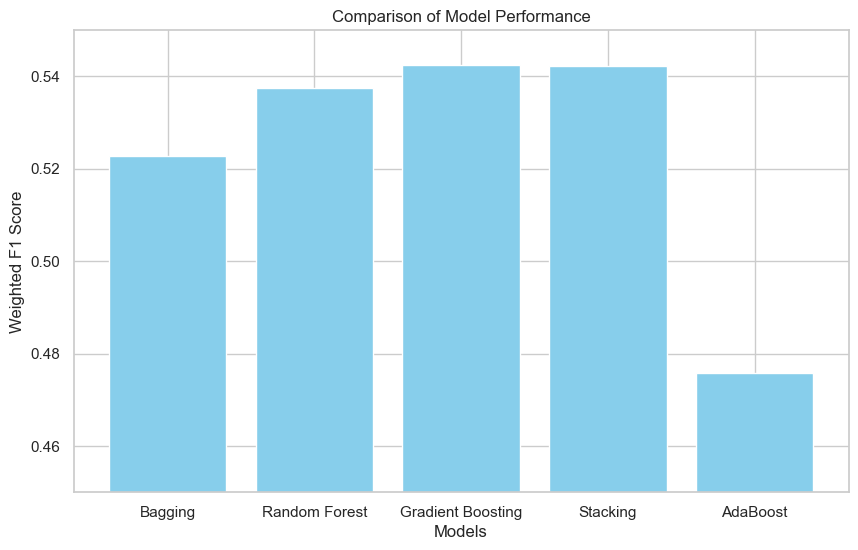

In [91]:
# F1 scores for each model
f1_scores = [
    f1_score(y_val_multiclass, y_pred_bagging_undersample_mc, average='weighted'),
    f1_score(y_val_multiclass, y_pred_rf_undersample, average='weighted'),
    f1_ensemble,
    f1_score(y_val_multiclass, y_pred_stacking, average='weighted'),
    f1_score(y_val_multiclass, y_pred, average='weighted')
]

# Model names
models = [
    'Bagging',
    'Random Forest',
    'Gradient Boosting',
    'Stacking',
    'AdaBoost'
]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Weighted F1 Score')
plt.title('Comparison of Model Performance')
plt.ylim([0.45, 0.55])  # Set the y-axis range if needed
plt.show()

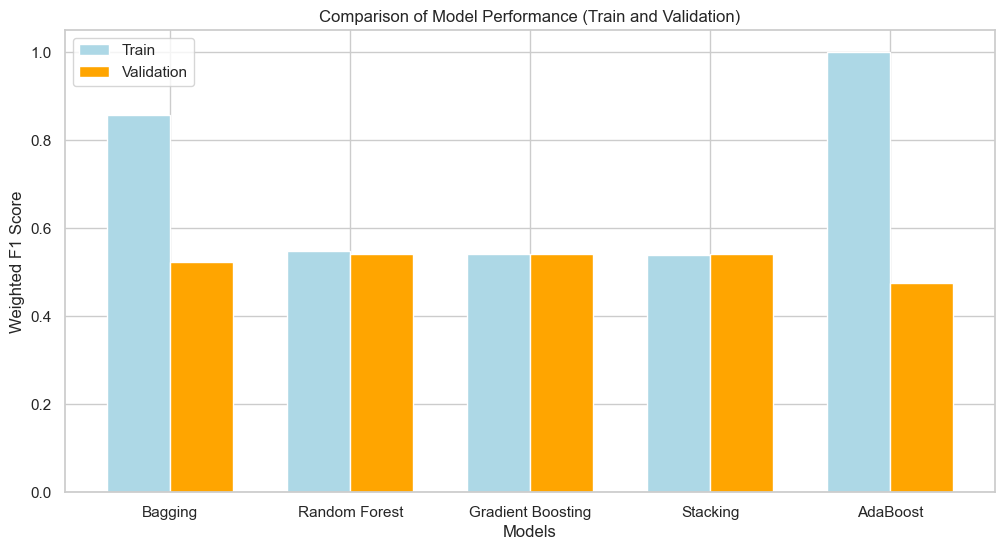

In [131]:
train_f1_scores = []
val_f1_scores = []

# Bagging
y_train_bagging_undersample_mc = bagging_under_multi.predict(X_train_undersampled_multi)
y_pred_bagging_undersample_mc = bagging_under_multi.predict(X_val_multi)
train_f1_scores.append(f1_score(y_train_undersampled_multi, y_train_bagging_undersample_mc, average='weighted'))
val_f1_scores.append(f1_score(y_val_multiclass, y_pred_bagging_undersample_mc, average='weighted'))

# Random Forest
y_train_rf_undersample = random_forest_under.predict(X_train_undersampled_multi)
y_pred_rf_undersample = random_forest_under.predict(X_val_multi)
train_f1_scores.append(f1_score(y_train_undersampled_multi, y_train_rf_undersample, average='weighted'))
val_f1_scores.append(f1_score(y_val_multiclass, y_pred_rf_undersample, average='weighted'))

# Gradient Boosting
y_pred = gradient_boost_model_multi.predict(X_val_multi)
y_train_pred = gradient_boost_model_multi.predict(X_train_undersampled_multi)
train_f1_scores.append(f1_score(y_train_undersampled_multi, y_train_pred, average='weighted'))
val_f1_scores.append(f1_score(y_val_multiclass, y_pred, average='weighted'))

# Stacking
y_train_stacking = stacking_model1.predict(X_train_undersampled_multi)
y_pred_stacking = stacking_model1.predict(X_val_multi)
train_f1_scores.append(f1_score(y_train_undersampled_multi, y_train_stacking, average='weighted'))
val_f1_scores.append(f1_score(y_val_multiclass, y_pred_stacking, average='weighted'))

# AdaBoost
y_pred = ada_boost_model_multi.predict(X_val_multi)
train_f1_scores.append(f1_score(y_train_undersampled_multi, y_train_undersampled_multi, average='weighted'))
val_f1_scores.append(f1_score(y_val_multiclass, y_pred, average='weighted'))

# Model names
models = [
    'Bagging',
    'Random Forest',
    'Gradient Boosting',
    'Stacking',
    'AdaBoost'
]

# Create a bar plot
bar_width = 0.35
index = range(len(models))

plt.figure(figsize=(12, 6))
plt.bar(index, train_f1_scores, width=bar_width, label='Train', color='lightblue')
plt.bar([i + bar_width for i in index], val_f1_scores, width=bar_width, label='Validation', color='orange')
plt.xlabel('Models')
plt.ylabel('Weighted F1 Score')
plt.title('Comparison of Model Performance (Train and Validation)')
plt.xticks([i + bar_width / 2 for i in index], models)
plt.legend()
plt.show()


Although Staking has a better f1 score in the validation dataset, the overfitting is negative. so the best model for ensemble using undersampled data is the Random Forest classifier